In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from glob import glob
import numpy as np
import xarray as xr
import pandas as pd
import yaml

## Make lists of possible tiles

- Open granule lists - filter on daylight and valid > threshold (0.25) 
- nc files contain valid flag for each pixel  
- sliding window through each granule (offset = ?) 
    - Is central pixel valid?
    - If yes, does whole tile have at least 90% (?) valid pixels?
    - If yes, save tile location in yaml (per granule)

Tile sizes:  
- 128 km = 16384 pixels
- 64 km = 4096 pixels

Cropped granule size:
- 512 x 2030
- but sometimes 512 x 2040 (not sure why)

In [2]:
# Save directory on Sense group workspace
save_dir = "/gws/nopw/j04/sensecdt/users/flojo/data/"

# Working folder
folder = "2021_test"
filepath = Path(save_dir+folder)

month = 1
satellite = 'aqua'

meta_filepath = filepath / str(month) / satellite / "meta"
granule_folder = filepath / str(month) / satellite / "granule_data"

In [3]:
with open(meta_filepath / "scene_ids.yaml", "r") as f:
    scene_ids = yaml.safe_load(f)

In [4]:
threshold = 0.25

# filter on day/night flag and valid pixels
filtered_scene_ids = {key:val for key, val in scene_ids.items() 
                        if val["day_night_flag"] == "DAY"
                        and val['valid_pixel_fraction'] > threshold
                        }

In [6]:
len(filtered_scene_ids)

76

In [7]:
filtered_scene_ids

{'MYD021KM.A2021001.1400': {'day_night_flag': 'DAY',
  'filepaths': {'data': '/neodc/modis/data/MYD021KM/collection61/2021/01/01/MYD021KM.A2021001.1400.061.2021002162349.hdf',
   'geolocation': '/neodc/modis/data/MYD03/collection61/2021/01/01/MYD03.A2021001.1400.061.2021002162018.hdf',
   'seaice': '/badc/ecmwf-era5/data/oper/an_sfc/2021/01/01/ecmwf-era5_oper_an_sfc_202101011400.ci.nc'},
  'regions': {'barents_fraction': 0.0,
   'gin_fraction': 0.0,
   'labrador_fraction': 0.59},
  'valid_pixel_fraction': 0.59},
 'MYD021KM.A2021001.1540': {'day_night_flag': 'DAY',
  'filepaths': {'data': '/neodc/modis/data/MYD021KM/collection61/2021/01/01/MYD021KM.A2021001.1540.061.2021002162404.hdf',
   'geolocation': '/neodc/modis/data/MYD03/collection61/2021/01/01/MYD03.A2021001.1540.061.2021002161819.hdf',
   'seaice': '/badc/ecmwf-era5/data/oper/an_sfc/2021/01/01/ecmwf-era5_oper_an_sfc_202101011500.ci.nc'},
  'regions': {'barents_fraction': 0.0,
   'gin_fraction': 0.0,
   'labrador_fraction': 0.81

In [5]:
granule = list(filtered_scene_ids.keys())[3]
granule

'MYD021KM.A2021002.1625'

In [6]:
ds = xr.open_dataset(granule_folder / f"{granule}.nc", engine = "h5netcdf")

In [7]:
ds

<xarray.Dataset> Size: 10MB
Dimensions:       (y: 2030, x: 512)
Coordinates:
    longitude     (y, x) float32 4MB ...
    latitude      (y, x) float32 4MB ...
Dimensions without coordinates: y, x
Data variables:
    study_region  (y, x) int8 1MB ...
    valid_pixel   (y, x) bool 1MB ...
Attributes:
    history:      Created by pytroll/satpy on 2025-01-09 13:32:31.508712
    Conventions:  CF-1.7

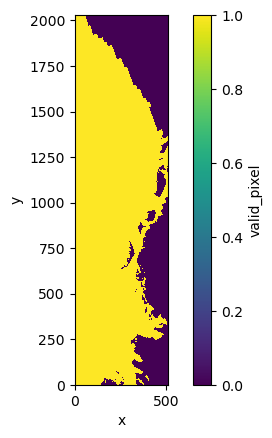

In [8]:
ds["valid_pixel"].plot()
plt.gca().set_aspect('equal')

In [ ]:
# need to define: size of tile, offset between tiles (stride)
# size of tile will determine position of first central pixel
# calculate max no. of tiles in x and y direction
# calculate position of central pixel in each tile
# for each possible tile, check valid and if so add to list of tiles
# how many possibilities do we need for sampling anchor and neighbour?
# need some kind of identifier for each valid tile within a granule? 
# But not tile_id as that would confuse things later
# poss use an i and j of tiles, grid should be the same for each slice, 
# then easy to relate anchors and neighbours
# so could simply make a list of valid (i,j) pairs for each granule
# need to list every i,j pair and whether valid or not, no can sample neighbours from
# all surrounding tiles.

In [9]:
granule_width = ds.sizes["x"] 
granule_height = ds.sizes["y"]

tile_size = 64
stride = 0.5

In [12]:
x = np.arange(tile_size/2, granule_width-tile_size/2+1, tile_size*stride).astype(int)
y = np.arange(tile_size/2, granule_height-tile_size/2+1, tile_size*stride).astype(int)
x, y

(array([ 32,  64,  96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416,
        448, 480]),
 array([  32,   64,   96,  128,  160,  192,  224,  256,  288,  320,  352,
         384,  416,  448,  480,  512,  544,  576,  608,  640,  672,  704,
         736,  768,  800,  832,  864,  896,  928,  960,  992, 1024, 1056,
        1088, 1120, 1152, 1184, 1216, 1248, 1280, 1312, 1344, 1376, 1408,
        1440, 1472, 1504, 1536, 1568, 1600, 1632, 1664, 1696, 1728, 1760,
        1792, 1824, 1856, 1888, 1920, 1952, 1984]))

## Pandas method

In [13]:
# make dataframe of tile positions
tile_map = pd.DataFrame([(i,j) for i in x for j in y], columns = ['x_c','y_c'])

In [18]:
tile_map

,scene_id,x_c,y_c,valid_tile,study_region,latitude,longitude
0,MYD021KM.A2021002.1625,32,32,True,1,48.514030,-48.538971
1,MYD021KM.A2021002.1625,32,64,True,1,48.797283,-48.632076
2,MYD021KM.A2021002.1625,32,96,True,1,49.081547,-48.727661
3,MYD021KM.A2021002.1625,32,128,True,1,49.364525,-48.822624
4,MYD021KM.A2021002.1625,32,160,True,1,49.642311,-48.923424
...,...,...,...,...,...,...,...
925,MYD021KM.A2021002.1625,480,1856,False,1,63.137005,-65.008842
926,MYD021KM.A2021002.1625,480,1888,False,0,63.401306,-65.275139
927,MYD021KM.A2021002.1625,480,1920,False,0,63.659943,-65.545334
928,MYD021KM.A2021002.1625,480,1952,False,0,63.923817,-65.824387


In [15]:
tile_map.insert(0, 'scene_id', granule) 


In [19]:
tile_map.pivot(index = 'x_c', columns = 'y_c')

valid_tile                                                                 \
y_c       31     47     63     79     95     111    127    143    159    175    
x_c                                                                             
31        True   True   True   True   True   True   True   True   True   True   
47        True   True   True   True   True   True   True   True   True   True   
63        True   True   True   True   True   True   True   True   True   True   
79        True   True   True   True   True   True   True   True   True   True   
95        True   True   True   True   True   True   True   True   True   True   
111       True   True   True   True   True   True   True   True   True   True   
127       True   True   True   True   True   True   True   True   True   True   
143      False   True   True   True   True   True   True   True   True   True   
159      False  False   True   True   True   True   True   True   True   True   
175      False  False   True   True   True   True   True   True   True   True   
191      False  False   True   True   True   True   True   True   True   True   
207      False  False   True   True   True   True   True   True   True   True   
223      False  False   True   True   True   True   True   True   True   True   
239      False   True  False   True   True   True   True   True   True   True   
255      False   True   True   True   True   True   True   True   True   True   
271      False   True   True   True   True   True   True   True   True   True   
287       True   True   True   True   True   True   True   True   True   True   
303       True   True   True   True  False  False  False  False   True   True   
319      False  False  False  False  False  False  False  False  False  False   
335      False  False  False  False  False  False  False  False  False  False   
351      False  False  False  False  False  False  False  False  False  False   
367      False  False  False  False  False  False  False  False  False  False   
383      False  False  False  False  False  False  False  False  False  False   
399      False  False  False  False  False  False  False  False  False  False   
415      False  False  False  False  False  False  False  False  False  False   
431      False  False  False  False  False  False  False  False  False  False   
447      False  False  False  False  False  False  False  False  False  False   
463      False  False  False  False  False  False  False  False  False  False   
479      False  False  False  False  False  False  False  False  False  False   

     ...  longitude                                                         \
y_c  ...       1839       1855       1871       1887       1903       1919   
x_c  ...                                                                     
31   ... -55.822060 -55.916260 -56.011215 -56.103317 -56.199963 -56.296886   
47   ... -56.183571 -56.279591 -56.376453 -56.470158 -56.568703 -56.667122   
63   ... -56.538105 -56.635956 -56.734653 -56.829887 -56.930313 -57.030182   
79   ... -56.886265 -56.985947 -57.086414 -57.183128 -57.285423 -57.386707   
95   ... -57.228668 -57.330143 -57.432320 -57.530468 -57.634579 -57.737270   
111  ... -57.565872 -57.669064 -57.772900 -57.872452 -57.978310 -58.082432   
127  ... -57.898384 -58.003220 -58.108677 -58.209602 -58.317142 -58.422722   
143  ... -58.226685 -58.333096 -58.440125 -58.542400 -58.651566 -58.758614   
159  ... -58.551186 -58.659126 -58.767723 -58.871334 -58.982075 -59.090565   
175  ... -58.872330 -58.981758 -59.091908 -59.196842 -59.309113 -59.419018   
191  ... -59.190540 -59.301411 -59.413101 -59.519356 -59.633110 -59.744411   
207  ... -59.506210 -59.618504 -59.731682 -59.839268 -59.954483 -60.067150   
223  ... -59.819725 -59.933437 -60.048027 -60.156975 -60.273636 -60.387646   
239  ... -60.131474 -60.246597 -60.362530 -60.472862 -60.590950 -60.706280   
255  ... -60.441841 -60.558346 -60.675579 -60.787323 -60.906807 -61.023453   
271  ..

In [20]:
ds["valid_pixel"].isel(x=slice(32-tile_size//2, 32+tile_size//2), 
                                               y=slice(32-tile_size//2, 32+tile_size//2))

<xarray.DataArray 'valid_pixel' (y: 64, x: 64)> Size: 4kB
[4096 values with dtype=bool]
Coordinates:
    longitude  (y, x) float32 16kB ...
    latitude   (y, x) float32 16kB ...
Dimensions without coordinates: y, x

In [21]:
# check each possible tile for valid pixels
tile_map['valid_tile'] = tile_map.apply(lambda x: (ds["valid_pixel"][x['y_c'], x['x_c']].values and
                                               ds["valid_pixel"].isel(x=slice(x['x_c']-tile_size//2, x['x_c']+tile_size//2), 
                                               y=slice(x['y_c']-tile_size//2, x['y_c']+tile_size//2)).values.mean() > 0.9).item(), 
                                               axis = 1)

tile_map['study_region'] = tile_map.apply(lambda x: ds["study_region"][x['y_c'], x['x_c']].item(), axis = 1)

tile_map['latitude'] =  tile_map.apply(lambda x: ds["latitude"][x['y_c'], x['x_c']].item(), axis = 1)
tile_map['longitude'] =  tile_map.apply(lambda x: ds["longitude"][x['y_c'], x['x_c']].item(), axis = 1)  

tile_map = tile_map.astype({'x_c': 'int16', 'y_c': 'int16', 'latitude': 'float32', 'longitude': 'float32',
                                        'study_region': 'int8'})   

In [17]:
tile_map.dtypes

x_c               int16
y_c               int16
valid_tile         bool
study_region       int8
latitude        float32
longitude       float32
dtype: object

In [35]:
tile_map.to_csv(meta_filepath / f"{granule}_tile_map.csv", index = False)

In [38]:
tile_map.to_pickle(meta_filepath / f"{granule}_tile_map.pkl")

In [38]:
tile_map.count()

x_c             930
y_c             930
valid_tile      930
study_region    930
latitude        930
longitude       930
dtype: int64

In [39]:
len(tile_map[tile_map['valid_tile']==True])

616

In [40]:
len(tile_map[tile_map['study_region'] == 1])

924

In [41]:
len(tile_map[tile_map['valid_tile'] & tile_map['study_region'] == 1])

616

In [252]:
rng = np.random.default_rng(seed=42)

In [253]:
# select a random pair of tiles
# need to also be able to select on study region
anchor = tile_map[tile_map['valid_tile']].sample(1)
anchor_x, anchor_y = anchor['x_c'].item(), anchor['y_c'].item()
anchor_x, anchor_y


(47, 927)

In [225]:
anchor_x, anchor_y = 143, 47

In [255]:
anchor_x, anchor_y

(47, 927)

In [254]:

# possible neighbours:
offset = tile_size//2
shifts = [(0,1),(0,-1),(1,0),(-1,0)]
neighbours = [(anchor_x + shift[0]*offset, anchor_y + shift[1]*offset) for shift in shifts]

neighbours

[(47, 959), (47, 895), (79, 927), (15, 927)]

In [256]:
for neighbour in neighbours:
    if tile_map.query(f"x_c == {neighbour[0]} and y_c == {neighbour[1]}")['valid_tile'].empty:
        neighbours.remove(neighbour)
    elif tile_map.query(f"x_c == {neighbour[0]} and y_c == {neighbour[1]}")['valid_tile'].item() == False:
        neighbours.remove(neighbour)
    else:
        continue

# if len(neighbours) == 0: choose new anchor
# else choose one of the neighbours

In [257]:
neighbours

[(47, 959), (47, 895), (79, 927)]

In [260]:
neighbour = rng.choice(neighbours)
tile_map.query('x_c == @neighbour[0] and y_c == @neighbour[1]')

,x_c,y_c,valid_tile,study_region,latitude,longitude
177,47,895,True,1,56.083168,-51.691334


In [244]:

neighbour_x = anchor_x + tile_offset[0].item()
neighbour_y = _anchor_y + tile_offset[1].item()
anchor_x, neighbour_x, _anchor_y, neighbour_y

(143, 175, 495, 495)

In [245]:
if tile_map.query('x_c == @neighbour_x and y_c == @neighbour_y').empty:
    print('no such tile')
elif tile_map.query('x_c == @neighbour_x and y_c == @neighbour_y')['valid_tile'].item():
    print('valid tile')
else:
    print('invalid tile')

valid tile


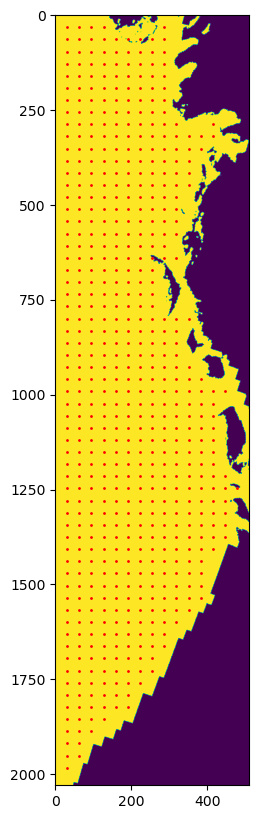

In [42]:
# plot valid tiles from dataframe
plt.figure(figsize=(10,10))
plt.imshow(ds["valid_pixel"])
plt.scatter(tile_map[tile_map['valid_tile']]['x_c'], tile_map[tile_map['valid_tile']]['y_c'], c = 'r', s = 1)


### As a function

In [22]:
def make_tile_list(scene_id, granule_filepath, meta_filepath, tile_size, stride, df_list = []):
    ''' Make a list of potential tile positions for each granule
    Check whether each tile has a valid pixel fraction above a threshold
    Save list of tile positions and metadata to a pickle file
    Count number of tiles in granule and add to scene_ids.yaml
    '''
    # open granule info nc file
    ds = xr.open_dataset(granule_filepath / f"{scene_id}.nc", engine = "h5netcdf")
    granule_width = ds.sizes["x"] 
    granule_height = ds.sizes["y"]

    # make grid of tile possible tile positions
    x = np.arange(tile_size/2, granule_width-tile_size/2+1, tile_size*stride).astype(int)
    y = np.arange(tile_size/2, granule_height-tile_size/2+1, tile_size*stride).astype(int)
    
    # make dataframe of tile positions
    tiles_df = pd.DataFrame([(i,j) for i in x for j in y], columns = ['x_c','y_c'])

    # check each possible tile for valid pixels and add metadata
    tiles_df['valid_tile'] = tiles_df.apply(
                            lambda x: (ds["valid_pixel"][x['y_c'], x['x_c']].values and
                            ds["valid_pixel"].isel(x=slice(x['x_c']-tile_size//2, x['x_c']+tile_size//2), 
                            y=slice(x['y_c']-tile_size//2, x['y_c']+tile_size//2)).values.mean() > 0.9).item(), 
                            axis = 1)

    tiles_df['study_region'] = tiles_df.apply(lambda x: ds["study_region"][x['y_c'], x['x_c']].item(), axis = 1)

    tiles_df['latitude'] =  tiles_df.apply(lambda x: ds["latitude"][x['y_c'], x['x_c']].item(), axis = 1)
    tiles_df['longitude'] =  tiles_df.apply(lambda x: ds["longitude"][x['y_c'], x['x_c']].item(), axis = 1)  

    tiles_df = tiles_df.astype({'x_c': 'int16', 'y_c': 'int16', 'latitude': 'float32', 'longitude': 'float32',
                                            'study_region': 'int8'})   

    # add to list for later concatenation
    tiles_df.insert(0, 'scene_id', scene_id) 
    df_list.append(tiles_df)

    # calculate number of valid tiles in each study region
    total_tiles = len(tiles_df[tiles_df['valid_tile']==True])
    lab_tiles = len(tiles_df[(tiles_df['valid_tile']==True) & (tiles_df['study_region']==1)])
    gin_tiles = len(tiles_df[(tiles_df['valid_tile']==True) & (tiles_df['study_region']==2)])
    barents_tiles = len(tiles_df[(tiles_df['valid_tile']==True) & (tiles_df['study_region']==3)])

    with open(meta_filepath / "scene_ids.yaml",'r') as f:
        # Need to load existing data first then append new variable...
        scene_ids = yaml.safe_load(f)
        scene_ids[scene_id][f'valid_tiles_{tile_size}px'] = {
                                            'total': total_tiles,
                                            'labrador_sea': lab_tiles,
                                            'gin_seas': gin_tiles,
                                            'barents_sea': barents_tiles}
    with open(meta_filepath / "scene_ids.yaml",'w') as f:
        yaml.dump(scene_ids, f)
    
    return df_list, total_tiles, lab_tiles, gin_tiles, barents_tiles

In [23]:
# input: month, year, satellite
month = '1'
year = '2021'
satellite = 'aqua'

tile_size = 64 # size of tile in pixels
stride = 0.5 # overlap of potential tile positions

threshold = 0.25 # threshold to filter out usable granules from scene_ids.yaml

# Save directory on Sense group workspace
save_dir = "/gws/nopw/j04/sensecdt/users/flojo/data/"

# Working folder
folder = year + "_test/"+ month +"/" + satellite 
# folder = year + "/" + satellite
filepath = Path(save_dir+folder)

meta_filepath = filepath / "meta"
granule_filepath = filepath / "granule_data"

with open(meta_filepath / "scene_ids.yaml", "r") as f:
    scene_ids = yaml.safe_load(f)

# filter on day/night flag and valid pixels
filtered_scene_ids = {key:val for key, val in scene_ids.items() 
                        if val["day_night_flag"] == "DAY"
                        and val['valid_pixel_fraction'] > threshold
                        }

df_list = []
total_total, lab_total, gin_total, barents_total = 0, 0, 0, 0

for scene_id in list(filtered_scene_ids.keys())[:10]:
    df_list, total_tiles, lab_tiles, gin_tiles, barents_tiles = \
        make_tile_list(scene_id, granule_filepath, meta_filepath, tile_size, stride, df_list)
    total_total += total_tiles
    lab_total += lab_tiles
    gin_total += gin_tiles
    barents_total += barents_tiles

tiles_df = pd.concat(df_list, ignore_index = True)
tiles_df.to_pickle(meta_filepath / f"tiles_{tile_size}px.pkl")

print(f"Total number of tiles: {total_total}")
print(f"Number of Labrador Sea tiles: {lab_total}")
print(f"Number of GIN Seas tiles: {gin_total}")
print(f"Number of Barents Sea tiles: {barents_total}")


Total number of tiles: 5157
Number of Labrador Sea tiles: 4763
Number of GIN Seas tiles: 394
Number of Barents Sea tiles: 0


In [60]:
all_tiles_df = pd.read_pickle("/home/users/flojo/sensecdt/users/flojo/data/2020_test/11/aqua/meta/all_tiles_64px.pkl")
all_tiles_df    

,scene_id,x_c,y_c,valid_tile,study_region,latitude,longitude
0,MYD021KM.A2020306.0940,31,31,False,0,58.828564,49.346725
1,MYD021KM.A2020306.0940,31,63,False,0,59.109951,49.207912
2,MYD021KM.A2020306.0940,31,95,False,0,59.390133,49.069412
3,MYD021KM.A2020306.0940,31,127,False,0,59.671360,48.926804
4,MYD021KM.A2020306.0940,31,159,False,0,59.951340,48.784908
...,...,...,...,...,...,...,...
81835,MYD021KM.A2020335.1540,479,1855,True,1,57.244183,-49.257118
81836,MYD021KM.A2020335.1540,479,1887,True,1,57.516796,-49.448376
81837,MYD021KM.A2020335.1540,479,1919,True,1,57.788456,-49.639858
81838,MYD021KM.A2020335.1540,479,1951,True,1,58.054020,-49.837273


In [62]:
scene_id = 'MYD021KM.A2020306.0940'
all_tiles_df.query('scene_id == @scene_id and valid_tile == True and study_region == 3')

,scene_id,x_c,y_c,valid_tile,study_region,latitude,longitude
45,MYD021KM.A2020306.0940,31,1471,True,3,71.234718,40.152725
46,MYD021KM.A2020306.0940,31,1503,True,3,71.505676,39.831760
47,MYD021KM.A2020306.0940,31,1535,True,3,71.775177,39.506550
48,MYD021KM.A2020306.0940,31,1567,True,3,72.045158,39.168556
49,MYD021KM.A2020306.0940,31,1599,True,3,72.313583,38.825012
...,...,...,...,...,...,...,...
925,MYD021KM.A2020306.0940,479,1855,True,3,72.333702,22.756952
926,MYD021KM.A2020306.0940,479,1887,True,3,72.565834,22.176088
927,MYD021KM.A2020306.0940,479,1919,True,3,72.796227,21.585827
928,MYD021KM.A2020306.0940,479,1951,True,3,73.019371,20.986408


## Dictionary method

In [122]:
tiles = np.array(np.meshgrid(x, y)).T.reshape(-1, 2).astype(int)

In [123]:
tiles

array([[  31,   31],
       [  31,   47],
       [  31,   63],
       ...,
       [ 479, 1951],
       [ 479, 1967],
       [ 479, 1983]])

In [ ]:
tiles_dict = {"x": int(x)}

In [117]:
tiles_dict = {f"{i}": {"x": int(x), "y": int(y)} for i, (x, y) in enumerate(tiles)}
tiles_dict

{'0': {'x': 31, 'y': 31},
 '1': {'x': 31, 'y': 47},
 '2': {'x': 31, 'y': 63},
 '3': {'x': 31, 'y': 79},
 '4': {'x': 31, 'y': 95},
 '5': {'x': 31, 'y': 111},
 '6': {'x': 31, 'y': 127},
 '7': {'x': 31, 'y': 143},
 '8': {'x': 31, 'y': 159},
 '9': {'x': 31, 'y': 175},
 '10': {'x': 31, 'y': 191},
 '11': {'x': 31, 'y': 207},
 '12': {'x': 31, 'y': 223},
 '13': {'x': 31, 'y': 239},
 '14': {'x': 31, 'y': 255},
 '15': {'x': 31, 'y': 271},
 '16': {'x': 31, 'y': 287},
 '17': {'x': 31, 'y': 303},
 '18': {'x': 31, 'y': 319},
 '19': {'x': 31, 'y': 335},
 '20': {'x': 31, 'y': 351},
 '21': {'x': 31, 'y': 367},
 '22': {'x': 31, 'y': 383},
 '23': {'x': 31, 'y': 399},
 '24': {'x': 31, 'y': 415},
 '25': {'x': 31, 'y': 431},
 '26': {'x': 31, 'y': 447},
 '27': {'x': 31, 'y': 463},
 '28': {'x': 31, 'y': 479},
 '29': {'x': 31, 'y': 495},
 '30': {'x': 31, 'y': 511},
 '31': {'x': 31, 'y': 527},
 '32': {'x': 31, 'y': 543},
 '33': {'x': 31, 'y': 559},
 '34': {'x': 31, 'y': 575},
 '35': {'x': 31, 'y': 591},
 '36': 

In [118]:


for key, tile in tiles_dict.items():
    x_c, y_c = tile["x"], tile["y"]
    valid = ds["valid_pixel"][y_c, x_c].values and \
    ds["valid_pixel"].isel(x=slice(x_c-tile_size//2+1, x_c+tile_size//2), 
                       y=slice(y_c-tile_size//2+1, y_c+tile_size//2)).values.mean() > 0.9
    tiles_dict[key]["valid"] = valid.item()

In [127]:
tiles

array([[  31,   31],
       [  31,   47],
       [  31,   63],
       ...,
       [ 479, 1951],
       [ 479, 1967],
       [ 479, 1983]])

In [99]:
x_c, y_c

(479, 1983)

In [103]:
tiles_dict

{'0': {'x': 31, 'y': 31, 'valid': False},
 '1': {'x': 31, 'y': 47, 'valid': False},
 '2': {'x': 31, 'y': 63, 'valid': False},
 '3': {'x': 31, 'y': 79, 'valid': False},
 '4': {'x': 31, 'y': 95, 'valid': False},
 '5': {'x': 31, 'y': 111, 'valid': False},
 '6': {'x': 31, 'y': 127, 'valid': False},
 '7': {'x': 31, 'y': 143, 'valid': False},
 '8': {'x': 31, 'y': 159, 'valid': False},
 '9': {'x': 31, 'y': 175, 'valid': False},
 '10': {'x': 31, 'y': 191, 'valid': False},
 '11': {'x': 31, 'y': 207, 'valid': False},
 '12': {'x': 31, 'y': 223, 'valid': False},
 '13': {'x': 31, 'y': 239, 'valid': False},
 '14': {'x': 31, 'y': 255, 'valid': False},
 '15': {'x': 31, 'y': 271, 'valid': False},
 '16': {'x': 31, 'y': 287, 'valid': False},
 '17': {'x': 31, 'y': 303, 'valid': False},
 '18': {'x': 31, 'y': 319, 'valid': False},
 '19': {'x': 31, 'y': 335, 'valid': False},
 '20': {'x': 31, 'y': 351, 'valid': False},
 '21': {'x': 31, 'y': 367, 'valid': False},
 '22': {'x': 31, 'y': 383, 'valid': False},
 '2

In [93]:
for key, tile in tiles_dict.items():
    print(tile['x'], tile['y'], tile['valid'])

31 31 False
31 47 False
31 63 False
31 79 False
31 95 False
31 111 False
31 127 False
31 143 False
31 159 False
31 175 False
31 191 False
31 207 False
31 223 False
31 239 False
31 255 False
31 271 False
31 287 False
31 303 False
31 319 False
31 335 False
31 351 False
31 367 False
31 383 False
31 399 False
31 415 False
31 431 False
31 447 False
31 463 False
31 479 False
31 495 False
31 511 False
31 527 False
31 543 False
31 559 False
31 575 False
31 591 False
31 607 False
31 623 False
31 639 False
31 655 False
31 671 False
31 687 False
31 703 False
31 719 False
31 735 False
31 751 False
31 767 False
31 783 False
31 799 False
31 815 True
31 831 True
31 847 True
31 863 True
31 879 True
31 895 True
31 911 True
31 927 True
31 943 True
31 959 True
31 975 True
31 991 True
31 1007 True
31 1023 True
31 1039 True
31 1055 True
31 1071 True
31 1087 True
31 1103 True
31 1119 True
31 1135 True
31 1151 True
31 1167 True
31 1183 True
31 1199 True
31 1215 True
31 1231 True
31 1247 True
31 1263 True
31 

(0.0, 2030.0)

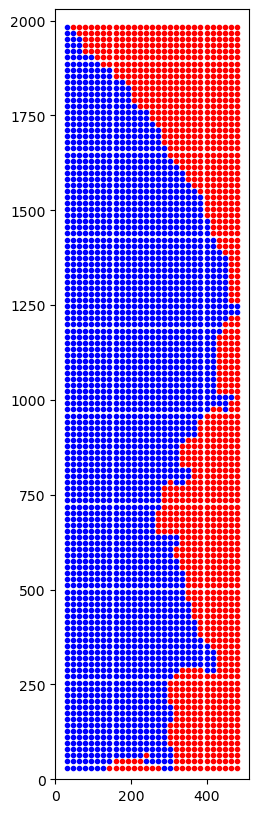

In [119]:
# plot valid locations
fig, ax = plt.subplots(figsize=(10, 10))
for key, tile in tiles_dict.items():
    if tile["valid"]:
        ax.plot(tile["x"], tile["y"], '.', color='blue')
    else:
        ax.plot(tile["x"], tile["y"], '.', color='red')

plt.gca().set_aspect('equal')
plt.gca().set_xlim([0, granule_width])
plt.gca().set_ylim([0, granule_height])

## List method

In [181]:
tiles = []

for i in range(len(x)):
    for j in range(len(y)):
        x_c = int(x[i])
        y_c = int(y[j])
        tiles.append(ds["valid_pixel"].isel(x=slice(x_c-tile_size//2+1, x_c+tile_size//2), 
                                  y=slice(y_c-tile_size//2+1, y_c+tile_size//2)).values.mean())
        

In [184]:
tiles.count(1), tiles.count(0)

(528, 364)

In [189]:
# Count how many are >0.9
tiles = np.array(tiles)
tiles[tiles > 0.9].shape


(536,)

In [191]:
536/930

0.5763440860215053

In [170]:
x_c-tile_size//2, x_c+tile_size//2

(319, 383)

In [ ]:
valid tiles